# Part B Recurrent Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed to handle sequential data, making them well-suited for tasks involving time series, natural language processing (NLP), and other sequential data domains. RNNs are tailored to capture dependencies within sequences. Their architecture includes hidden states that maintain a memory of past inputs, allowing them to consider context and sequential information.RNNs are particularly effective in tasks like language modeling, machine translation, and speech recognition.

## Initializing Libaries

In [189]:
import tensorflow as tf
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from wordcloud import WordCloud

## Checking GPU

In [82]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Setting Random Seed

In [83]:
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

## Problem Statement
Our Goal of this project is to build a next-word predictor, given a sequence of words. Our model should also produce different sequences of words given the same input.
## Goals of this project
### Generalization
> We need a model that generalizes well to different input sequences beyond the training data.
### Accuracy of Predictions
> We need to make our model accurately predicts the next word in a given sequence, especially for the provided seed_texts. Idealy around 85% of our choosen evaluation metrics
### Variabilty in Output
> We need to create a model that is capable of producing different and diverse sequences for the same input.

# Importing Dataset

In [84]:
df = pd.read_csv('./datasets/train.csv')
print(df)

                                                Quotes
0    Embrace the beauty of every sunrise; it's a fr...
1    Embrace challenges; they are the stepping ston...
2    Embrace the rhythm of life and let it dance th...
3    Embrace kindness, for it has the power to chan...
4    Embrace the journey, for it leads to the desti...
..                                                 ...
995  With an open heart, welcome the opportunities ...
996  This morning, let your laughter be the music t...
997  In the serenity of this morning, find the powe...
998  This morning, let your actions be a testament ...
999  With each sunrise, this morning offers the pro...

[1000 rows x 1 columns]


In [85]:
print(f'There are {len(df)} quotes in this dataset.')
df.head(5)

There are 1000 quotes in this dataset.


,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."


# EDA
What insights can we get from our data?
- What is the frequency distribution of words in our dataset?
- What is the distribution of lengths of quotes from our dataset? Are there any outliers?

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Quotes  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


### Checking for any Missing or Null Values

In [87]:
df.isnull().sum()

Quotes    0
dtype: int64

### Checking for duplicates

In [88]:
duplicates = df.duplicated()
print(f'Number of duplicate rows = {duplicates.sum()}')

Number of duplicate rows = 110


In [89]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)
duplicate_rows = df.duplicated()
print(f'Number of duplicate rows = {duplicate_rows.sum()}')
df

Number of duplicate rows = 0


,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
885,"With an open heart, welcome the opportunities ..."
886,"This morning, let your laughter be the music t..."
887,"In the serenity of this morning, find the powe..."
888,"This morning, let your actions be a testament ..."


### Checking for Numerical values

In [90]:
is_numeric = df['Quotes'].apply(lambda x: str(x).isnumeric())
print(f'Number of numeric quotes = {is_numeric.sum()}')

Number of numeric quotes = 0


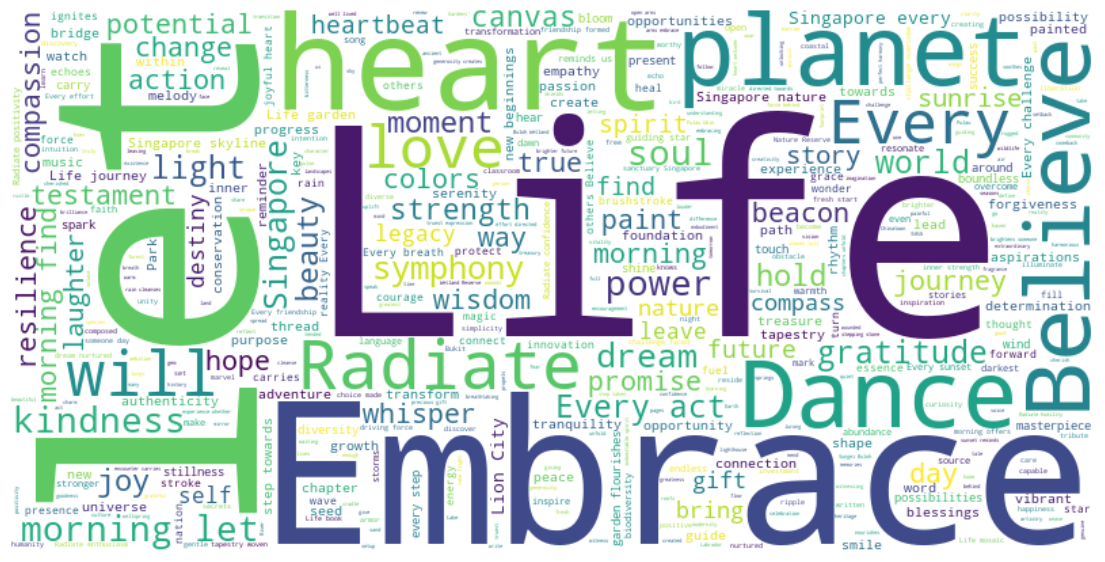

In [91]:
text = " ".join(quote for quote in df.Quotes)

# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400, max_words=5000).generate(text)

# Display the generated image
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Observations:
- We can see that the words, "Let" , "Life" , "Embrace" and "heart" are the most common words found in our dataset. 
- We would expect the words, "the","and" as the most common words but we dont see them.This happens because wordcloud automatically removes common stopswords like "the" "and" "is"  to focus on meaningful words and avoid cluttering the visualization with frequently occurring but less informative words.

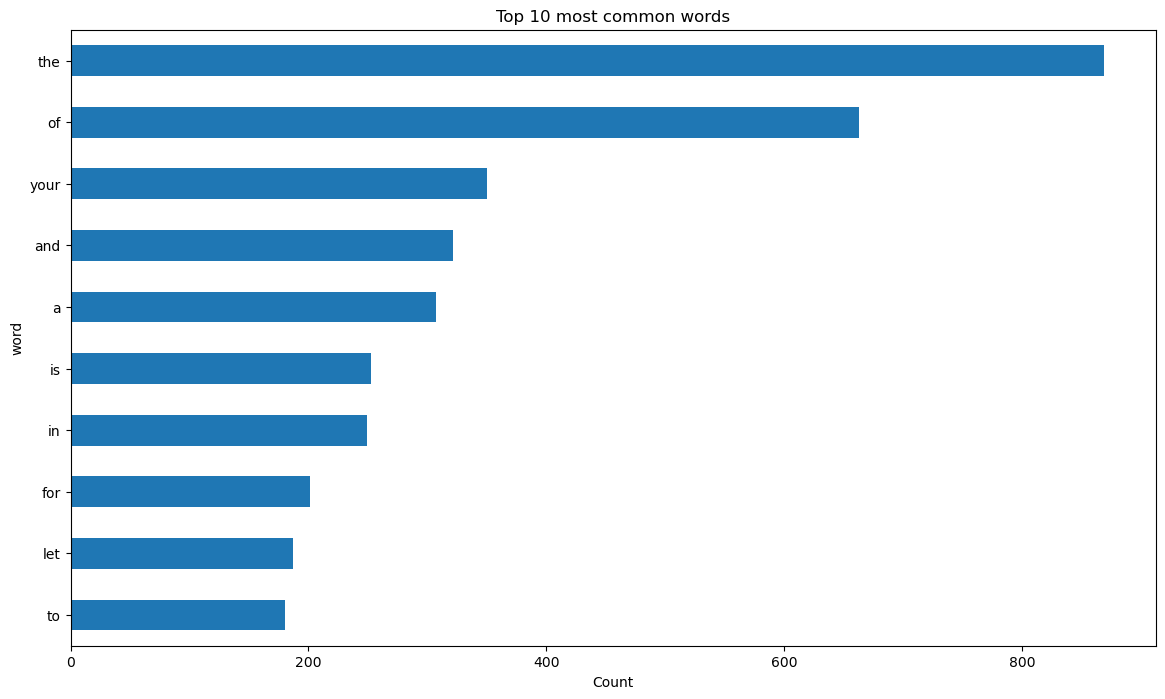

In [92]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['Quotes'])
word_counts = tokenizer.word_counts
common_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

df_common_words.sort_values(by='count').plot(kind='barh', x='word', y='count', legend=False,figsize=(14,8))
plt.xlabel('Count')
plt.title('Top 10 most common words')
plt.show()

Observations:
- The most frequent words are now the common stopwords like "the", "of", "your" and "and". 
- Without wordcloud automatically removing them we can see that all of the top 10 most common words found in our dataset are stop words.

In [93]:
num_unique_words = len(tokenizer.word_index) + 1 # +1 for padding
print(f'Number of unique words: {num_unique_words}')

Number of unique words: 1199


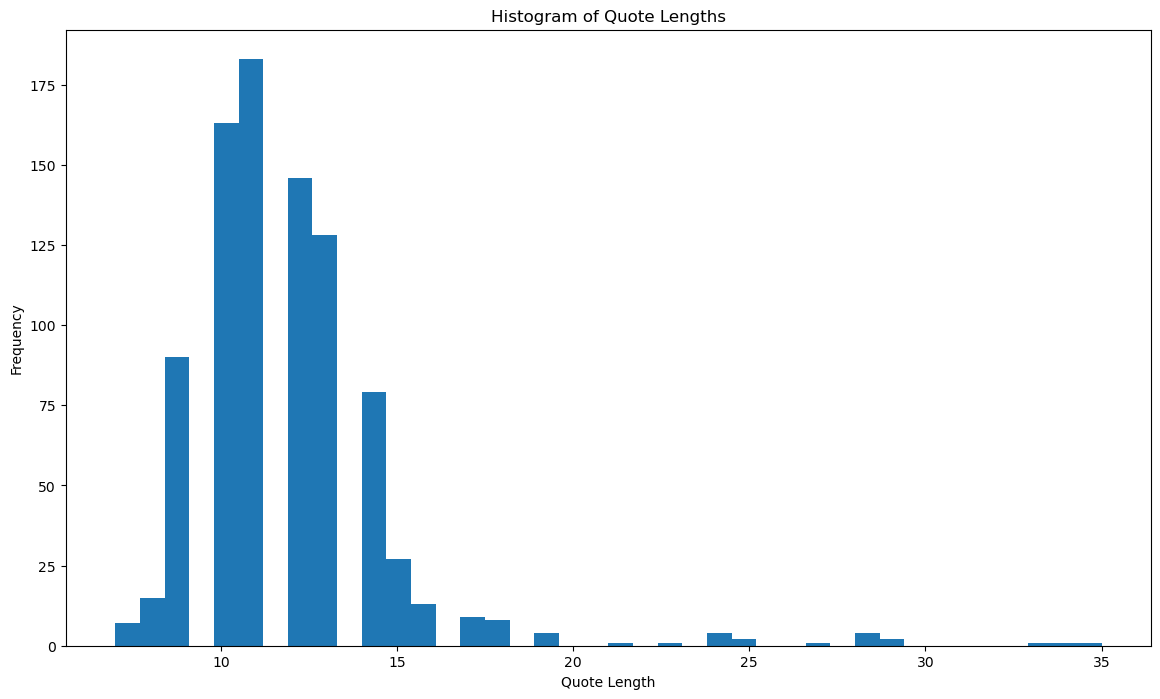

In [94]:
tokenizer = Tokenizer()
# Fit the tokenizer on the quotes
tokenizer.fit_on_texts(df['Quotes'])
# Get the sequences of tokens for each quote
sequences = tokenizer.texts_to_sequences(df['Quotes'])
# Get the word length of each quote
df['Quote Word Length'] = [len(seq) for seq in sequences]

# Create a histogram of quote lengths
df['Quote Word Length'].plot(kind='hist', bins=40,figsize=(14,8))
plt.xlabel('Quote Length')
plt.title('Histogram of Quote Lengths')
plt.show()

Observations:
- We can see that most quotes are around 10-12 words long, with a few outliers at around 35 words long
- We might need to pad sequences to a length slightly beyond our typical quote length to capture the majority of our quotes effectively.

### Phrase Analysis

In [95]:
for i in range(2,5):
    vectorizer = CountVectorizer(ngram_range=(i, i))
    X = vectorizer.fit_transform(df['Quotes'])
    df_ngrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    bigram_counts = df_ngrams.sum()
    common_ngrams = bigram_counts.nlargest(10)
    print(f'\nCommon {i}-grams:')
    print(common_ngrams)


Common 2-grams:
be the          126
let your        124
in the          101
this morning     97
of your          96
for it           93
our planet       92
embrace the      89
believe in       84
in yourself      83
dtype: int64

Common 3-grams:
believe in yourself    83
for it is              65
in yourself and        63
it is the              61
and you will           53
yourself and you       52
dance through the      51
this morning let       51
and let it             46
morning let your       41
dtype: int64

Common 4-grams:
believe in yourself and    63
for it is the              57
in yourself and you        52
yourself and you will      52
this morning let your      41
and let it be              38
let it be the              37
embrace the power of       25
believe in yourself for    20
of this morning find       20
dtype: int64


Observations:
- We can see from analysing our phrases that the sentiment of our text data is leaning more towards a motivational and positve tone.
    - Recurring motifs such as self-belief and taking action
    - We can see that many n-grams convey positive and motivational themes, encouraging personal growth, confidence, and positive actions.

# Data Preprocessing
We will be doing these few steps to prepocesses our text data.
- Finding any unsual words in the English language
- Cleaning our text
- Lemmitimizing our data
- Input-output pairs

## Finding any unusual words in the English Language

In [96]:
nltk.download('words')
nltk.download('punkt')
from nltk.corpus import words
words.readme().replace('\n', ' ')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'Wordlists  en: English, http://en.wikipedia.org/wiki/Words_(Unix) en-basic: 850 English words: C.K. Ogden in The ABC of Basic English (1932) '

In [97]:
from nltk import word_tokenize
text_tokenized = df['Quotes'].apply(word_tokenize)
english_vocab = set(w.lower() for w in words.words())

text_vocab = set(w.lower() for quote in text_tokenized for w in quote if w.isalpha() and not w.endswith(('s', 'ing', 'ed', 'er', 'ly','est')))

unusual = text_vocab.difference(english_vocab)

print(unusual)

{'ubin', 'hindhede', 'timah', 'semakau', 'merlion', 'skyline', 'soundtrack', 'kranji', 'tekong', 'hantu', 'buloh', 'wetland', 'pulau', 'changi', 'sentosa', 'coney', 'punggol', 'jawa', 'batok', 'bukit', 'brushstroke', 'asia', 'chek', 'clarke', 'jurong', 'singapore', 'peranakan', 'sungei', 'macritchie', 'biodiversity'}


Observations:
- We can see that most unusual words our code has found are words mostly used in Singapore's context, for example "punggol" where this is not an english word but in Malay.It suggests that, this text is unique in the context of Singapore where we have a mix of many different cultures and thus implement words from all types of langugaes apart from English in our daily speaking habits.

## Cleaning our Text
We will be cleaning our text from punctuation, 
removing any special characters that may not convey meaningful information and lastly convert all our text to lowercase to ensure uniformity

In [98]:
import string

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove special characters
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Apply text cleaning to the 'Quotes' column
df['Quotes'] = df['Quotes'].apply(clean_text)
df

,Quotes,Quote Word Length
0,embrace the beauty of every sunrise its a fres...,16
1,embrace challenges they are the stepping stone...,11
2,embrace the rhythm of life and let it dance th...,12
3,embrace kindness for it has the power to chang...,16
4,embrace the journey for it leads to the destin...,12
...,...,...
885,with an open heart welcome the opportunities a...,15
886,this morning let your laughter be the music th...,16
887,in the serenity of this morning find the power...,18
888,this morning let your actions be a testament t...,18


## Lemmitimizing our data
It involves reducing our words to their base or dictionary forms, known as lemmas. For example, the lemma of "dancing" is dance. We will be trying it out on our models to see whether it improves its performance

### How does it help?
There are many ways in theory for lemmitimizing our words that will help our model.
- It helps reduce our vocabulary size by grouping inflected forms together, thus reducing training times
- Lemmatization may help the RNN generalize more effectively as our model may learn patterns and relationships that are applicable across various forms of a word.

However, lemmitimizing our words can lead to loss in infomation,especially if our specific inflection of a word carries important context. For example "Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy" the lemma of "its" is "it". With "it" replacing "its", the sentence changes to not making much sense anymore.

We will test it on our model to see how our model performs when presented with lemmitimized input-output sequences as compared to without.

In [99]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Define a function that lemmatizes each word in a text
def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in words])

# Apply the function to your DataFrame
# Assuming 'text_column' is the name of the column containing the text
df['Lemmitized_Quotes'] = df['Quotes'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [100]:
df

,Quotes,Quote Word Length,Lemmitized_Quotes
0,embrace the beauty of every sunrise its a fres...,16,embrace the beauty of every sunrise it a fresh...
1,embrace challenges they are the stepping stone...,11,embrace challenge they are the stepping stone ...
2,embrace the rhythm of life and let it dance th...,12,embrace the rhythm of life and let it dance th...
3,embrace kindness for it has the power to chang...,16,embrace kindness for it ha the power to change...
4,embrace the journey for it leads to the destin...,12,embrace the journey for it lead to the destina...
...,...,...,...
885,with an open heart welcome the opportunities a...,15,with an open heart welcome the opportunity and...
886,this morning let your laughter be the music th...,16,this morning let your laughter be the music th...
887,in the serenity of this morning find the power...,18,in the serenity of this morning find the power...
888,this morning let your actions be a testament t...,18,this morning let your action be a testament to...


## Input-Output pairs

In [101]:
#convert our df into a list
quotes = df['Quotes'].tolist()
lemmatized_quotes = df['Lemmitized_Quotes'].tolist()
quotes[:5]

['embrace the beauty of every sunrise its a fresh chance to paint your world with joy',
 'embrace challenges they are the stepping stones to your greatest victories',
 'embrace the rhythm of life and let it dance through your soul',
 'embrace kindness for it has the power to change the world one heart at a time',
 'embrace the journey for it leads to the destination of your dreams']

In [102]:
#tokenize our quotes
tokenizer = Tokenizer()
tokenizer_lem = Tokenizer()
tokenizer.fit_on_texts(quotes)
tokenizer_lem.fit_on_texts(lemmatized_quotes)
print("Without Lemmitimzing:\n",tokenizer.word_index)
print("\n")
print("With Lemmitimzing:\n",tokenizer_lem.word_index)

Without Lemmitimzing:
 {'the': 1, 'of': 2, 'your': 3, 'and': 4, 'a': 5, 'is': 6, 'in': 7, 'for': 8, 'let': 9, 'to': 10, 'it': 11, 'be': 12, 'every': 13, 'our': 14, 'you': 15, 'that': 16, 'embrace': 17, 'lifes': 18, 'this': 19, 'are': 20, 'morning': 21, 'with': 22, 'radiate': 23, 'dance': 24, 'heart': 25, 'believe': 26, 'yourself': 27, 'through': 28, 'planets': 29, 'will': 30, 'life': 31, 'love': 32, 'they': 33, 'singapores': 34, 'kindness': 35, 'power': 36, 'from': 37, 'dreams': 38, 'we': 39, 'soul': 40, 'symphony': 41, 'act': 42, 'find': 43, 'gratitude': 44, 'singapore': 45, 'strength': 46, 'world': 47, 'light': 48, 'beauty': 49, 'journey': 50, 'nature': 51, 'joy': 52, 'planet': 53, 'canvas': 54, 'colors': 55, 'way': 56, 'whispers': 57, 'where': 58, 'potential': 59, 'hope': 60, 'testament': 61, 'resilience': 62, 'towards': 63, 'true': 64, 'new': 65, 'compassion': 66, 'hearts': 67, 'beacon': 68, 'actions': 69, 'future': 70, 'spirit': 71, 'step': 72, 'change': 73, 'wisdom': 74, 'moments

In [103]:
total_words = len(tokenizer.word_index) + 1 # Because index 0 is reserved for padding.
total_words_lemmatized = len(tokenizer_lem.word_index) + 1 # Because index 0 is reserved for padding.
print(f'Total words without lemmatizing: {total_words}\n')
print(f'Total words with lemmatizing: {total_words_lemmatized}\n')

Total words without lemmatizing: 1200

Total words with lemmatizing: 1069



In [104]:
for i in range(5):
    print(f'Quote {i+1}:')
    print(quotes[i])
    print(tokenizer.texts_to_sequences([quotes[i]])[0])

Quote 1:
embrace the beauty of every sunrise its a fresh chance to paint your world with joy
[17, 1, 49, 2, 13, 78, 118, 5, 164, 481, 10, 99, 3, 47, 22, 52]
Quote 2:
embrace challenges they are the stepping stones to your greatest victories
[17, 148, 33, 20, 1, 369, 482, 10, 3, 370, 681]
Quote 3:
embrace the rhythm of life and let it dance through your soul
[17, 1, 119, 2, 31, 4, 9, 11, 24, 28, 3, 40]
Quote 4:
embrace kindness for it has the power to change the world one heart at a time
[17, 35, 8, 11, 149, 1, 36, 10, 73, 1, 47, 371, 25, 483, 5, 296]
Quote 5:
embrace the journey for it leads to the destination of your dreams
[17, 1, 50, 8, 11, 248, 10, 1, 682, 2, 3, 38]


In [105]:
input_sequences = []
input_sequences_lem = []
for line in quotes:
    # Convert our line into a sequence of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    token_list_lem = tokenizer_lem.texts_to_sequences([line])[0]
    input_sequences.append(token_list)
    input_sequences_lem.append(token_list_lem)

print(f'Number of input sequences: {len(input_sequences)}')

Number of input sequences: 890


In [106]:
print(input_sequences)

[[17, 1, 49, 2, 13, 78, 118, 5, 164, 481, 10, 99, 3, 47, 22, 52], [17, 148, 33, 20, 1, 369, 482, 10, 3, 370, 681], [17, 1, 119, 2, 31, 4, 9, 11, 24, 28, 3, 40], [17, 35, 8, 11, 149, 1, 36, 10, 73, 1, 47, 371, 25, 483, 5, 296], [17, 1, 50, 8, 11, 248, 10, 1, 682, 2, 3, 38], [17, 3, 484, 8, 11, 6, 1, 683, 2, 3, 40, 91, 1, 120], [17, 1, 212, 105, 8, 11, 6, 1, 485, 371, 16, 297, 684], [17, 3, 372, 8, 33, 82, 1, 165, 10, 298, 3, 64, 59], [17, 44, 4, 130, 213, 11, 486, 1, 131, 7, 3, 31], [17, 1, 132, 8, 11, 373, 1, 110, 2, 3, 70, 166], [17, 1, 57, 2, 3, 25, 33, 167, 1, 74, 2, 1, 120], [17, 79, 8, 11, 6, 1, 133, 2, 5, 150, 25], [17, 1, 36, 2, 106, 8, 11, 374, 15, 299, 37, 1, 487, 2, 1, 375], [17, 1, 685, 11, 686, 376, 187, 249, 488, 489], [17, 1, 490, 75, 8, 33, 687, 82, 1, 370, 688], [17, 32, 8, 11, 6, 1, 214, 2, 1, 40], [17, 73, 8, 11, 6, 1, 485, 689, 7, 18, 300, 690], [17, 1, 691, 8, 11, 92, 1, 76, 2, 65, 134], [17, 3, 38, 8, 33, 20, 1, 491, 2, 3, 93], [17, 1, 55, 2, 31, 215, 7, 1, 692, 2,

In [107]:
final_input_output_pair = []
final_input_output_pair_lem = []
for x in range(max([len(x) for x in input_sequences]) - 1): 
    # print(x)
    input_output_pairs = []
    for datapoint in input_sequences:
        for i in range(len(datapoint) - x -1): # Why -1?
            input_output_pairs.append(datapoint[i:i + x + 2])
    final_input_output_pair += input_output_pairs
        
    # print(f'Total number of input-output pairs is: {len(input_output_pairs)}')

for x in range(max([len(x) for x in input_sequences_lem]) - 1):
    input_output_pairs_lem = []
    for datapoint in input_sequences_lem:
        for i in range(len(datapoint) - x -1): # Why -1?
            input_output_pairs_lem.append(datapoint[i:i + x + 2])
    final_input_output_pair_lem += input_output_pairs_lem

print(f'The total number of input-output pairs without Lemmitimizing are: {len(final_input_output_pair)}\n')
print(f'The total number of input-output pairs with Lemmitimizing are: {len(final_input_output_pair_lem)}\n')

The total number of input-output pairs without Lemmitimizing are: 61838

The total number of input-output pairs with Lemmitimizing are: 50912



### Pad our Sequences

In [108]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len_lem = max([len(x) for x in input_sequences_lem])
final_input_output_pair = np.array(sequence.pad_sequences(final_input_output_pair, maxlen=max_sequence_len, padding='pre'))
final_input_output_pair_lem = np.array(sequence.pad_sequences(final_input_output_pair_lem, maxlen=max_sequence_len_lem, padding='pre'))
print(final_input_output_pair.shape)
print(final_input_output_pair_lem.shape)

(61838, 35)
(50912, 35)


## Train test split

In [109]:
X = final_input_output_pair[:,:-1]
y = final_input_output_pair[:,-1]
X_lem = final_input_output_pair_lem[:,:-1]
y_lem = final_input_output_pair_lem[:,-1]

print(X[:5])
print(y[:5])

print(X.shape)
print(y.shape)
print(X_lem.shape)
print(y_lem.shape)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 49]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 13]]
[ 1 49  2 13 78]
(61838, 34)
(61838,)
(50912, 34)
(50912,)


### One hot encode y

In [110]:
y = utils.to_categorical(y, num_classes=total_words)
y_lem = utils.to_categorical(y_lem, num_classes=total_words_lemmatized)
print(y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_train_lem.shape)
print(y_train.shape)
print(y_train_lem.shape)

print(X_test.shape)
print(X_test_lem.shape)
print(y_test.shape)
print(y_test_lem.shape)

(49470, 34)
(40729, 34)
(49470, 1200)
(40729, 1069)
(12368, 34)
(10183, 34)
(12368, 1200)
(10183, 1069)


We will be splitting our data into train and test sets as we want to get a numerical understanding of how would the model perform on unseen data. However our model's next word prediction can be incohirent even though the loss curve shows that the model is performing well, So we need human interpretation to assess our model together with other evaluation metrics like perplexity.

# Models
We will be trying out 2 types of models for our next text prediction project:
- Baseline RNN
- Long Short-Term Memory (LSTM)

The baseline RNN will be the model that we will be comparing the other model off on. As they are supposedly better than the baseline recurant neural network. As they solve the vanishing gradient problem that RNNs seem to have.

### What makes a RNN different?
<img src="./images/unrolled-rnn.png" style="width: 30%">

[[Source]](https://builtin.com/data-science/recurrent-neural-networks-and-lstm)

The main feature that sets RNNs apart from ANNs is the presence of __recurrent connections__, which create loops that feed into itself in the network. This allows infomation to be passed from one step of the sequence to the next, enabling the network to maintain context and capture dependencies through time.

They are also designed to handle sequences of different lengths as the recurrent connections enables them to maintain a hidden state that evolves as the sequence progresses.
### Main Challenges
As our RNN continues to unfold and more sequences are added to it, it faces a problem where the gradient from back propagation becomes either too large or too small. Thus our optimization algorithm takes either a huge or a very small step to get to a local minima. The gradients either explode or diminish exponentially with each additional time step. To solve this, we can use more advanced RNN architechture such as LSTMs and GRUs. or we can limit the magnitude of gradients during training to prevent them from becoming too large.

## What does the Embedding layer do?
We want similar words that mean the same thing have similar numbers assigned to them! In this way our RNN would not need more complexity and training as learning how to correctly process similar words with similar meanings. So that learning how to use 1 word will help learn how to use the other word at the same time. We can do this by creating a vector space where words with similar meanings are close together. The Embedding layer converts discrete words or tokens into continuous, dense vectors.

### Evaluation metrics
We will be using __perplexity__ and __human assesment__ to assess our models
#### Perplexity
It measures how well a probability distribution or a language model predicts a sample. In other words it measures how well the probability distribution predicted by a model aligns with the actual distribution of words in a dataset. A lower perplexity indicates a better alignment. The formula is as such:

$$ PP = \exp\left(\frac{1}{N} \sum_{i=1}^{N} -\log P(x_i)\right) $$

Where:
- $ PP $ is the perplexity.
- $ N $ is the total number of words in the sequence.
- $ P(x_i) $ is the predicted probability assigned by the model to the actual word $ x_i $.
- $ \log $ is the natural logarithm.
- $ \exp $ is the exponentiation function.

It provides a quantitative measure of how well the model is capturing the patterns and structure of the language in the training data. However, quantitative measurements are not always accurate in measuring the model's performance thus we will also assess it with the text it has predicted and see whether there is any inconsistencies in the text.

<!-- - need to combat overfitting
- maybe when the model is performing good on paper(loss graph), it gives out incohirent answers to us
- evaluation models on metrics such as perplexity and human assesment -->
<!-- - such as perplexity or BLEU score) and qualitative evaluation (human assessment).
- word embeding, we wont be using word2vec as it is a pretrained model -->

In [112]:
def predict_next_word(input_text, model, tokenizer, max_sequence_len, temperature=1.0):
    tokens = tokenizer.texts_to_sequences([input_text])[0]
    tokens = sequence.pad_sequences([tokens], maxlen=max_sequence_len-1, padding='pre')

    # Apply temperature to the predicted logits
    predictions = model.predict(tokens, verbose=0)
    predictions = np.log(predictions) / temperature
    exp_predictions = np.exp(predictions)
    probabilities = exp_predictions / np.sum(exp_predictions, axis=-1)

    # Sample from the adjusted probabilities
    predicted_word_index = np.random.choice(len(probabilities[0]), p=probabilities[0])
    predicted_word = tokenizer.index_word.get(predicted_word_index, "")

    return predicted_word

def generate_text_with_temperature(model, tokenizer, seed_text, max_sequence_len, temperature=1.0, num_words=15):
    output_text = seed_text
    for _ in range(num_words):
        predicted_word = predict_next_word(output_text, model, tokenizer, max_sequence_len, temperature=temperature)
        output_text += " " + predicted_word
    return output_text

def plot_loss_curve(history):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
def calculate_perplexity(model, X_test, y_test):
    # Predict probabilities for each class
    predictions = model.predict(X_test)

    # Flatten the arrays
    predictions_flat = predictions.flatten()
    y_test_flat = y_test.flatten()

    # Calculate negative log likelihood
    nll = -np.log(predictions_flat[np.where(y_test_flat == 1)])

    # Calculate and return perplexity
    perplexity = np.exp(np.mean(nll))
    return perplexity

def evaluate_save_model(model,model_name,save_dir='./models',save_models=False, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, total_words=total_words):
    # Create directory if it doesn't exist
    if save_models:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        # Save the model
        model_path = os.path.join(save_dir, model_name + '.h5')
        #replace the model if it already exists
        if os.path.exists(model_path):
            os.remove(model_path)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)

        model_history = model.history.history
        # Convert float32 values to float
        for key in model_history.keys():
            model_history[key] = [float(val) for val in model_history[key]]

        if os.path.exists(os.path.join(save_dir, model_name +'_history'+'.json')):
            os.remove(os.path.join(save_dir, model_name + '_history'+'.json'))
        json.dump(model_history, open(os.path.join(save_dir, model_name +'_history'+ '.json'), 'w'))
        print('Saved trained model history at %s ' % os.path.join(save_dir, model_name +'_history'+ '.json'))
    else:
        model_history = model.history.history
    result = {}
    best_epoch = np.argmin(model_history['val_loss'])
    result["Model Name"] = model_name
    result['train_loss'] = model_history['loss'][best_epoch]
    result['val_loss'] = model_history['val_loss'][best_epoch]
    result['train_perplexity'] = calculate_perplexity(model,X_train,y_train)
    result['val_perplexity'] = calculate_perplexity(model,X_test,y_test)
    result_series = pd.Series(result, name=result["Model Name"])
    return result_series

## Baseline RNN

We will be making a simple RNN model, with an Embedding layer to convert our token into vectors. A RNN layer with 128 cells and with a dropout layer to reduce overfitting and ending off with a output dense layer to predict the word. This will serve as a base for the rest of our models to continue improving off on. We will be using a batch size of 128 as with batch size 64, the RNN takes too long to train and thus due to time considerations we will be using batch size 128.

In [113]:
from tensorflow.keras.layers import SimpleRNN
tf.keras.backend.clear_session()
baseline_RNN = Sequential()
baseline_RNN.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
baseline_RNN.add(SimpleRNN(128, return_sequences=False))
baseline_RNN.add(Dense(total_words, activation='softmax'))
baseline_RNN.add(Dropout(0.2))
baseline_RNN.compile(loss='categorical_crossentropy', optimizer='adam')
baseline_RNN.summary()

history_baselineRNN = baseline_RNN.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=128,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 10)            12000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               17792     
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 184,592
Trainable params: 184,592
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
387/387 [==============================] - 14s 34ms/step - loss: 7.3389 - val_loss: 4.8190
Epoch 2/100
387/387 [==============================] - 13s 33ms/step - loss: 6.

In [114]:
evaluate_save_model(baseline_RNN,'Baseline_RNN',save_models=True)

Saved trained model at ./models\Baseline_RNN.h5 
Saved trained model history at ./models\Baseline_RNN_history.json 
387/387 [==============================] - 2s 5ms/step


Model Name          Baseline_RNN
train_loss              3.795201
val_loss                1.197233
train_perplexity        2.043883
val_perplexity          3.379157
Name: Baseline_RNN, dtype: object

In [115]:
seed_texts = ['embrace each day',
 'radiate some',
 'believe that',
 "life's actual purpose is",
 'dance through each and every',
 'let your time and energy',
 'every person is',
 'our country Singapore is',
 'planet earth is',
 'morning and evening would make it']

In [146]:
for seed_text in seed_texts:
    print(generate_text_with_temperature(baseline_RNN, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day is a reminder of the marvel of existence and the boundless possibilities it brings the
radiate some strength and let it be the lighthouse in the storms of life and possibility within
believe that make our sense of purpose they are the sweetest that success our dreams and aspirations
life's actual purpose is the gift of a brighter tomorrow that this morning offers the promise of a fresh
dance through each and every symphony into hearts and growth it follow threads of inspiration for they hold the hues
let your time and energy that punggol you home us with the echoes of your journey a tale worth telling
every person is composed of the moments the tranquility of the heart a serene state where joy and
our country Singapore is an investment in your future success our planet our every future of the beauty in
planet earth is the compass that leads you to happiness and become stronger touch and soul and aspirations
morning and evening would make it with the hues of our dreams 

Observations:
- If we skim through the predicted text, it will look ok at first glance. However when we read each line individually, we find that the sentences either does not make sense or the sentences are a combination of 2 seperate sentences.
- This relates to our high val_perplexity as compared to train_perplexity. From the results we can see that our model is not learning well to generalise to unseen data this suggests that our model maybe overfitting or our model architechture maybe too simple for our model to learn complex features leading to difficulties in generalization.

## Baseline with Lemmitimization
We will be trying to train our model with the Lemmitimized dataset, and see how it affects our model. The reason behind choosibng lemmatization lies in its potential to address issues related to vocabulary size, word redundancy, and overall model comprehension. Hopefully improving the model's ability to extract meaningful patterns.

### Hypothetical Goal of our Model
We hope that the inclusion of lemmatization  may lead to more efficient feature extraction and contribute to a reduction in the model's susceptibility to noise in the data. 

In [117]:
baseline_RNN_lem = Sequential()
baseline_RNN_lem.add(Embedding(total_words_lemmatized, 10, input_length=max_sequence_len_lem-1))
baseline_RNN_lem.add(SimpleRNN(128, return_sequences=False))
baseline_RNN_lem.add(Dense(total_words_lemmatized, activation='softmax'))
baseline_RNN_lem.add(Dropout(0.2))
baseline_RNN_lem.compile(loss='categorical_crossentropy', optimizer='adam')
baseline_RNN_lem.summary()

history_baselineRNN_lem = baseline_RNN_lem.fit(X_train_lem, y_train_lem, epochs=100, verbose=1, validation_data=(X_test_lem, y_test_lem),batch_size=128,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 10)            10690     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               17792     
                                                                 
 dense_1 (Dense)             (None, 1069)              137901    
                                                                 
 dropout_1 (Dropout)         (None, 1069)              0         
                                                                 
Total params: 166,383
Trainable params: 166,383
Non-trainable params: 0


_________________________________________________________________
Epoch 1/100
319/319 [==============================] - 10s 30ms/step - loss: 7.1690 - val_loss: 4.7209
Epoch 2/100
319/319 [==============================] - 10s 31ms/step - loss: 6.6280 - val_loss: 4.0030
Epoch 3/100
319/319 [==============================] - 11s 34ms/step - loss: 6.0196 - val_loss: 3.4569
Epoch 4/100
319/319 [==============================] - 11s 34ms/step - loss: 5.6397 - val_loss: 3.0767
Epoch 5/100
319/319 [==============================] - 11s 34ms/step - loss: 5.3753 - val_loss: 2.7984
Epoch 6/100
319/319 [==============================] - 10s 33ms/step - loss: 5.1502 - val_loss: 2.5679
Epoch 7/100
319/319 [==============================] - 10s 31ms/step - loss: 4.9637 - val_loss: 2.3945
Epoch 8/100
319/319 [==============================] - 10s 33ms/step - loss: 4.8426 - val_loss: 2.2680
Epoch 9/100
319/319 [==============================] - 10s 31ms/step - loss: 4.7608 - val_loss: 2.1455
Epoch 1

In [118]:
evaluate_save_model(baseline_RNN_lem,'Baseline_RNN_lem',save_models=True,X_train=X_train_lem,y_train=y_train_lem,X_test=X_test_lem,y_test=y_test_lem,total_words=total_words_lemmatized)

Saved trained model at ./models\Baseline_RNN_lem.h5 
Saved trained model history at ./models\Baseline_RNN_lem_history.json 
319/319 [==============================] - 2s 6ms/step


Model Name          Baseline_RNN_lem
train_loss                  3.858542
val_loss                    1.307824
train_perplexity            2.237974
val_perplexity              3.776213
Name: Baseline_RNN_lem, dtype: object

In [147]:
for seed_text in seed_texts:
    print(generate_text_with_temperature(baseline_RNN, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day is a reminder of the preciousness of life and the gentle goodbyes it knows the
radiate some lifes transition from land to sea of life and possibility it conspire the promise of
believe that soothes and uplifts to new beginnings and fresh opportunities that ignites change to the seeds
life's actual purpose is the music of the soul of the soul a tale worth telling freedom story us
dance through each and every we light to the world its our spirit and growth and light that meaningful connections
let your time and energy that defy logic and touch the soul of destiny transition to your character of a
every person is a canvas for new beginnings reminding us of the preciousness of every day brighter future
our country Singapore is knows no bounds a unique mark in full bloom with empathy of joy and hope
planet earth is a reminder of the cycles of life on our planet lead the way in your
morning and evening would make it defines the world one heart at in your destiny each decisio

Observations:
- We can see that as compared to no Lemmitization, the val perplexity does not exhibit a improvement. This suggests that lemmatization may not always guarantee better generalization to unseen data.
    - This may be because to serveral reasons:
        - The reduction in vocabulary size achieved through lemmatization might not always be beneficial. In some cases, preserving the diversity of words could aid the model in capturing nuanced relationships.
        - While lemmatization aims to normalize grammatical forms, it might inadvertently oversimplify the language, potentially causing the model to lose some contextual nuances.
- There is not much of a difference of meaning from the predicted text as compared to the lemmitimized text, it suggests that lemmatixzation has not drastically altered  context of our generated sequences.

## Baseline With Gradient Clipping
We will be implementing gradient clipping to somewhat combat the exploding gradient problem and hope to see how effectively gradient clipping can mitigate the challenges associated with large gradient values during the optimization process.

### Exploding Gradient Problem
The exploding gradient problem occurs when the gradients in a neural network become excessively large during the backpropagation phase escpescially prominant in RNNs. This phenomenon can lead to unstable training, making it difficult for the model to converge to a local minima. Gradient clipping serves as a potential remedy by imposing a constraint on the gradient values, preventing them from surpassing a predefined threshold.

In [120]:
from tensorflow.keras.optimizers import Adam
tf.keras.backend.clear_session()

baseline_RNN_GC = Sequential()
baseline_RNN_GC.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
baseline_RNN_GC.add(SimpleRNN(128, return_sequences=False))
baseline_RNN_GC.add(Dense(total_words, activation='softmax'))
baseline_RNN_GC.add(Dropout(0.2))

optimizer = Adam(clipvalue=1)

baseline_RNN_GC.compile(loss='categorical_crossentropy', optimizer=optimizer)
baseline_RNN_GC.summary()

history_baselineRNN_GP = baseline_RNN_GC.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=128,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 10)            12000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               17792     
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 184,592
Trainable params: 184,592
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
387/387 [==============================] - 16s 33ms/step - loss: 7.3454 - val_loss: 4.8095
Epoch 2/100
387/387 [==============================] - 12s 32ms/step - loss: 6.

In [121]:
evaluate_save_model(baseline_RNN_GC,'Baseline_RNN_GP',save_models=True)

Saved trained model at ./models\Baseline_RNN_GP.h5 
Saved trained model history at ./models\Baseline_RNN_GP_history.json 
387/387 [==============================] - 2s 5ms/step


Model Name          Baseline_RNN_GP
train_loss                 3.840153
val_loss                   1.194211
train_perplexity           2.064309
val_perplexity             3.348999
Name: Baseline_RNN_GP, dtype: object

In [148]:
for seed_text in seed_texts:
    print(generate_text_with_temperature(baseline_RNN_GC, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day is a harmonious symphony and new beginnings reminding us of the preciousness of every day
radiate some peace and create a haven of tranquility around you towards the power to create magic
believe that new wellspring of strength and abundance is the music of the soul and soul resonate
life's actual purpose is woven with threads of love and laughter into the sunrise chest a return more powerful
dance through each and every intertwine is a reminder of the preciousness of life and the gentle goodbyes of this
let your time and energy is palpable connections is the sky with wonder of the human spirit and unwavering determination
every person is woven with threads of love and joy stronger more blessings in your life a plant
our country Singapore is an investment in a brighter future in the realization of your purpose and within every
planet earth is a force a story worthy worthy of your empathy of your understanding for within every
morning and evening would make it by the lo

Observations:
- The validation perplexity is still higher than the training perplexity, but the gap seems to be reduced somewhat as compared to our model without any gradient clipping. 
- The coherency for sentences are good for the first few words , however sentences start to not make sense after its 6th-7th prediction.

## LSTM

### Introduction to LSTMs
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) architecture designed to address the challenges of RNNs. The vanishing or exploding gradient problem. First introduced in a paper "Long short-term memory" in 1997 by researchers Josef "Sepp" Hochreiter and Jürgen Schmidhuber. As seen in the earlier baseline RNN model, we encounter with a quite a big problem of vanishing/ exploding gradients, with training times becoming exceptionally long to train.
### Architechture
<img src="./images/LSTM_architechture.png" style="width: 40%">

[[Source]](https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c)




LSTMs are equipped with memory cells (as seen above) that can store and retrieve information over long periods. There are 2 seperate paths to make predictions, one path is for long term memories ($C_{t-1}$) and one is for short term memories ($H_{t-1}$).

We can see the __Memory line__ $C_{t-1}$ that runs through the top of the cell. That is the long term memory. Notice how there are no weights to modify the long term memory, this allows our long term memories to flow through our unrolled units without causing our gradient to explode or vanish.

We can see the __Hidden state__ $H_{t-1}$ thats runs through the bottom of the cell. This is the short term memory, they are connected to weights that can modify them.

The __Forget Gate__$F_t$ decides on what percentage should the long term memory be rembered. As the sigmoid activation function turns any number between 0 and 1. and we times that result with the current long term memory.

The __Candidate memory__ and the Input Gate $I_t$ work to together to decide on whether a new long term memory will be added to $C_{t-1}$. The Candidate memory combibnes the short-term memory and the input to create a potential long-term memory. And the Input Gate $I_t$ determines what percentage of the potential long term memory to add to the existing long-term memory.

The Final __output gate__ $o_t$ updates the short term memory, we start off with the new long term memory and use as the input into the tanh activation function. This represents a potential short term memory and now the LSTM has to decide on what percentage of the short term memory to remember we use a sigmoid activation function to determine the percentage. Then we get our new short term memory by multipling them together where we get $H_t$.
### Why LSTMs?
- LSTMs fix the problem of vanishing or exploding gradients encountered by basic RNNS.
- Specialized gates to control what information from the previous time step should be discarded, helping mitigate the vanishing gradient problem. and gating mechanisms to control the flow of gradients during backpropagation to preventing them from exploding.

### Why we wont be using Lemmitimization
- In our project, we want to preserve our word variations to capture meanings in our text.
- We can see that lemmatization oversimplifies word forms and leads to the loss of contextual information, when reading the predicted text.
- Eventhough we can see better results in our perplexity when using lemmatixation, we will be not using it due to project specifications.

## Base LSTM
We will be changing our base model's Simple RNN layer to a LSTM Layer and changing the batch size to 64. and we will see our results

### Anticipanted Outcome
We hope that the introduction of LSTM layers will enhance our model's ability to capture long-term dependencies, potentially improving performance on sequential data tasks. 

In [123]:
tf.keras.backend.clear_session()
baseline_LSTM = Sequential()
baseline_LSTM.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
baseline_LSTM.add(LSTM(128, return_sequences=False))
baseline_LSTM.add(Dense(total_words, activation='softmax'))
baseline_LSTM.add(Dropout(0.2))
baseline_LSTM.compile(loss='categorical_crossentropy', optimizer='adam')
baseline_LSTM.summary()
history_baselineLSTM = baseline_LSTM.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           120000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 392,048
Trainable params: 392,048
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 7s 7ms/step - loss: 7.0130 - val_loss: 4.3177
Epoch 2/100
773/773 [==============================] - 5s 7ms/step - loss: 6.1975

In [124]:
evaluate_save_model(baseline_LSTM,'Baseline_LSTM',save_models=True)

Saved trained model at ./models\Baseline_LSTM.h5 
Saved trained model history at ./models\Baseline_LSTM_history.json 
387/387 [==============================] - 1s 2ms/step


Model Name          Baseline_LSTM
train_loss               3.759911
val_loss                 1.031606
train_perplexity         1.978904
val_perplexity            2.84288
Name: Baseline_LSTM, dtype: object

In [150]:
from warnings import filterwarnings
filterwarnings('ignore')
for seed_text in seed_texts:
    print(generate_text_with_temperature(baseline_LSTM, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day brings new opportunities to shine for it is the heartbeat of humanity within and let
radiate some wisdom for it carries the bright future success around you have the power of selfdiscovery
believe that meaningful connections bring to life and let go of what no longer serves you are
life's actual purpose is a liberation of the universe within them with others arms and fresh are enough just
dance through each and every breath let gratitude fill your lungs and heart reminding you of lifes refreshment and renewal
let your time and energy that our planet offers to brighter when we spread kindness and joy will follow the
every person is a leap of faith for it is the heartbeat of a joyful heart and soul
our country Singapore is a testament to endurance and breathtaking views singapores nature is diverse and breathtaking views singapores
planet earth is a gift a precious jewel in the cosmos deserves our utmost care for they paint
morning and evening would make it transforms th

Observations:
- Our base LSTM performs better than our RNNs models, with lower perplexity scores.
- We can see that LSTM solves the vanishing / exploding gradient problem with training times being x2 as fast, with 2 times less of a batch size.
- Our predicted text has more coherence in it, with words forming more meaningful sequences compared to the RNN models. 
    - This improvement in language generation can be attributed to our LSTM's ability to selectively retain and forget information through its memory cell mechanism, allowing for better long-term dependencies in the generated sequences.

## LSTM with 2 layers
We will be  adding a new LSTM layer for greater model complexity and hopefully achieve better perplexity.

### Why?
It stems from the recognition that deeper architectures can potentially extract more abstract and complex features from our data, leading our model to learn hierarchical representations, which may be helpful in our project.

In [126]:
tf.keras.backend.clear_session()
LSTM_2l = Sequential()
LSTM_2l.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
LSTM_2l.add(LSTM(128, return_sequences=True))
LSTM_2l.add(LSTM(128, return_sequences=False))
LSTM_2l.add(Dense(total_words, activation='softmax'))
LSTM_2l.compile(loss='categorical_crossentropy', optimizer='adam')
LSTM_2l.summary()

history_LSTM = LSTM_2l.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           120000    
                                                                 
 lstm (LSTM)                 (None, 34, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1200)              154800    
                                                                 
Total params: 523,632
Trainable params: 523,632
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 10s 10ms/step - loss: 5.0388 - val_loss: 4.3957
Epoch 2/100
773/773 [==============================] - 7s 10ms/step - loss: 4.0

In [127]:
evaluate_save_model(LSTM_2l,'LSTM_2l',save_models=True)

Saved trained model at ./models\LSTM_2l.h5 
Saved trained model history at ./models\LSTM_2l_history.json 
387/387 [==============================] - 1s 3ms/step


Model Name           LSTM_2l
train_loss          0.748037
val_loss            1.154937
train_perplexity    1.978773
val_perplexity      3.218373
Name: LSTM_2l, dtype: object

In [151]:

filterwarnings('ignore')
for seed_text in seed_texts:
    print(generate_text_with_temperature(LSTM_2l, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day is a step towards excellence and progress no longer serves you to new adventures with
radiate some possibilities to alter to change a lifes course to be the turning point in someones
believe that reverberates in the heart spreading warmth and happiness far and wide that version of yourself
life's actual purpose is the day with strength and let it flow through your being embrace your soul they
dance through each and every day is a precious gift you can give to another and progress and vision of
let your time and energy a reminder of the preciousness of life light in every heart at a life welllived
every person is a story a story worthy worthy of your empathy of your understanding for within every
our country Singapore is a testament to diversity and our planet holds the potential it brings your way we
planet earth is a beauty in faith is a step towards miracles the extraordinary moments that defy logic
morning and evening would make it with threads of love and joy will 

Observations:
- We can see that with greater model complexity, our LSTM model performs worse than our base LSTM model. With the perplexity being slighty higher
    - Showing that increased model depth did not necessarily translate to improved language understanding or prediction accuracy.
- The sentences are less conherant and lack the smooth flow we observed in the predictions of the base LSTM model.

## LSTM with double the amount of neurons
As seen from the observations above, increasing our model complexity with additional layers does not improve our results at all.
Lets try increasing the model complexity in a single layer, not by adding another layer. and see how the results are like. 

We hope that with more neurons, we can increase the feature representation capacity of the LSTM layer this could lead to a better understanding of sequential patterns and contribute to improving our language modeling.

In [129]:
tf.keras.backend.clear_session()
LSTM_2xNeurons = Sequential()
LSTM_2xNeurons.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
LSTM_2xNeurons.add(LSTM(256, return_sequences=False))
LSTM_2xNeurons.add(Dense(total_words, activation='softmax'))
LSTM_2xNeurons.add(Dropout(0.2))
LSTM_2xNeurons.compile(loss='categorical_crossentropy', optimizer='adam')
LSTM_2xNeurons.summary()
history_2xNeuronsLSTM = LSTM_2xNeurons.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           120000    
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense (Dense)               (None, 1200)              308400    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 793,968
Trainable params: 793,968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 7s 7ms/step - loss: 6.8617 - val_loss: 3.9872
Epoch 2/100
773/773 [==============================] - 5s 7ms/step - loss: 5.8772

In [130]:
evaluate_save_model(LSTM_2xNeurons,'LSTM_2xNeurons',save_models=True)

Saved trained model at ./models\LSTM_2xNeurons.h5 
Saved trained model history at ./models\LSTM_2xNeurons_history.json 
387/387 [==============================] - 1s 3ms/step


Model Name          LSTM_2xNeurons
train_loss                3.744195
val_loss                  1.033009
train_perplexity          1.956438
val_perplexity            2.856978
Name: LSTM_2xNeurons, dtype: object

In [172]:
filterwarnings('ignore')
for seed_text in seed_texts:
    print(generate_text_with_temperature(LSTM_2xNeurons, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day with a heart full of gratitude is a step a step towards the tranquility of
radiate some joy and let it be the armor that shields your heart write the way for
believe that is a testament to your indomitable spirit and strength to connect and uplift to create
life's actual purpose is the essence of true beauty and dreams aspirations and actions brings the path providing strength
dance through each and every day is a gift that keeps on giving knows the moments that take days day
let your time and energy to moments of happiness and contentment reside in the world like the rising sun let
every person is limitless in the beauty of simplicity and grass a testament to endurance and adaptation the
our country Singapore is a testament to the beauty of our diversity and actions leads the masterpiece that is
planet earth is a gift a testament to your indomitable spirit a living proof of your strength and
morning and evening would make it holds the power to transform hearts and min

Observations:
- We can see that we have simliar results as compared to our baseline LSTM
- The sentences are quite coherant and convey meaningful messages

# Model Improvement
__What can we do to improve our models?__ 

We will be experimenting with:
- Adding a learning rate scheduler 
- Bi-directionaly LSTMs in our model 

We will be using our LSTM model with double the amount of neurons as eventhough the base and the 2XLSTM model has very similar results. With greater amount of neurons, our 2xLSTM will have a increased feature representation than our base. 

### Why?

__Learning rate scheduler:__
- As adjusting the learning rate during training can significantly impact the model's convergence and generalization capabilities. As when our model is reaching close to a local minima, we want it to take even smaller and careful steps to not overshoot it.

__Bidirectional LSTM:__
- As bidirectional LSTMs are designed to capture dependencies in both forward and backward directions within sequential data, we hope that including bidirectional processing can enhance our model's contextual understanding, allowing it to leverage information from both past and future time steps. 

### Learning rate scheduler

In [163]:
from tensorflow.keras.callbacks import LearningRateScheduler

LSTM_lr = Sequential()
LSTM_lr.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
LSTM_lr.add(LSTM(256, return_sequences=False))
LSTM_lr.add(Dense(total_words, activation='softmax'))
LSTM_lr.add(Dropout(0.2))
LSTM_lr.compile(loss='categorical_crossentropy', optimizer='adam')
LSTM_lr.summary()

def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule)

history_2xNeuronsLSTM_lr = LSTM_lr.fit(
    X_train, 
    y_train, 
    epochs=100, 
    verbose=1, 
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
        lr_scheduler 
    ]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 100)           120000    
                                                                 
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dense_1 (Dense)             (None, 1200)              308400    
                                                                 
 dropout_1 (Dropout)         (None, 1200)              0         
                                                                 
Total params: 793,968
Trainable params: 793,968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 8s 8ms/step - loss: 6.8293 - val_loss: 3.8856 - lr: 0.0010
Epoch 2/100
773/773 [==============================] - 6s 7ms/step

In [164]:
evaluate_save_model(LSTM_lr,'LSTM_lr',save_models=True)

Saved trained model at ./models\LSTM_lr.h5 
Saved trained model history at ./models\LSTM_lr_history.json 
387/387 [==============================] - 1s 2ms/step


Model Name           LSTM_lr
train_loss          3.706229
val_loss            1.000072
train_perplexity    1.932728
val_perplexity      2.735417
Name: LSTM_lr, dtype: object

In [165]:
filterwarnings('ignore')
for seed_text in seed_texts:
    print(generate_text_with_temperature(LSTM_lr, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day is a canvas woven with threads of resilience and warmth and happiness far and wide
radiate some authenticity for it is the gateway to its a time of biodiversity and resilience and
believe that creates waves of kindness and kindness that resonates in the hearts of others and love
life's actual purpose is a testament to the beauty of the human spirit and strength of our spirit and
dance through each and every day is a canvas for new beginnings reminding us of the preciousness of every day
let your time and energy it radiates from your heart to the world around you within you are not alone
every person is a fresh start for new beginnings reminding us of the preciousness of every day with
our country Singapore is an opportunity for growth for they are the compass of your heart lead the way
planet earth is a canvas for new beginnings and compassion that reside within you of lifes precious gifts
morning and evening would make it be the foundation of your success for it is th

Observations:
- We can see that our perplexity has gone down due to learning rate scheduling, it shows that our model has converged more effectively, resulting in improved generalization to unseen data.
- The sentences are more coherant and meaningful. The use of a learning rate schedule has likely helped our model find a better balance in adjusting the weights during training.

### Bi-directional LSTMs
__What are Bi-directional LSTMS?__

Is it a type of LSTM that processes input data in both forward and backward directions. Unlike traditional LSTMs, which only consider past context, bi-directional LSTMs take into account both past and future context when making predictions or learning representations.

<img src="./images/Bidirectional-LSTM.jpg" style="width: 40%">

[[Source]](https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/)

The outputs from the forward and backward passes are combined at each time step. This combination of information from both directions provides a more comprehensive context for each time step.This bidirectional nature allows our model to capture patterns that depend on both past and future context. 

In [166]:
from tensorflow.keras.layers import Bidirectional
tf.keras.backend.clear_session()
biLSTM = Sequential()
biLSTM.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
biLSTM.add(Bidirectional(LSTM(256, return_sequences=False)))
biLSTM.add(Dense(total_words, activation='softmax'))
biLSTM.add(Dropout(0.2))
biLSTM.compile(loss='categorical_crossentropy', optimizer='adam')
biLSTM.summary()
history_biLSTM = biLSTM.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           120000    
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1200)              615600    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 1,466,736
Trainable params: 1,466,736
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 11s 12ms/step - loss: 6.6148 - val_loss: 3.2972
Epoch 2/1

In [167]:
evaluate_save_model(biLSTM,'biLSTM',save_models=True)

Saved trained model at ./models\biLSTM.h5 
Saved trained model history at ./models\biLSTM_history.json 
387/387 [==============================] - 1s 4ms/step


Model Name            biLSTM
train_loss          3.769302
val_loss            1.027133
train_perplexity    1.949873
val_perplexity      2.893488
Name: biLSTM, dtype: object

In [168]:
filterwarnings('ignore')
for seed_text in seed_texts:
    print(generate_text_with_temperature(biLSTM, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day with a heart full of gratitude is a step towards a joyful heart at peace
radiate some hope and let it be the sunrise in your darkest nights which you find the
believe that guides you home your purpose and aspirations and understanding will you will be a beacon
life's actual purpose is your journey a fresh start for new beginnings reminding us of the preciousness of every
dance through each and every decision shaping the masterpiece that is your unique life story worthy worthy of compassion and
let your time and energy it can mend hearts and restore faith and you will break through any obstacle that
every person is a classroom where we learn to love ourselves let go of what no longer serves
our country Singapore is a testament to the beauty of the human spirit of our planet and aspirations and
planet earth is the cradle tended canvases of natures palette and strength a step towards endurance and inner
morning and evening would make it defines the community for a garden 

Observations:
- We can see that with the inclusion of Bi-directionaly LSTMs, our sentences are less coherant than compared without the inclusion of BI-directionaly LSTMs.
- Our perplexity remains the same. 
- It suggests that bidirectional information might not contribute positively to our model's understanding.

### Adding Learning Rate scheduler to our Bidirectional LSTM

Will our Bidirectionaly LSTM model improve enough after adding a learning rate scheduler?

In [169]:
tf.keras.backend.clear_session()
biLSTM_lr = Sequential()
biLSTM_lr.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
biLSTM_lr.add(Bidirectional(LSTM(256, return_sequences=False)))
biLSTM_lr.add(Dense(total_words, activation='softmax'))
biLSTM_lr.add(Dropout(0.2))
biLSTM_lr.compile(loss='categorical_crossentropy', optimizer='adam')
biLSTM_lr.summary()
history_biLSTM_lr = biLSTM_lr.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=64,
                                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                                             lr_scheduler])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           120000    
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1200)              615600    
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
Total params: 1,466,736
Trainable params: 1,466,736
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
773/773 [==============================] - 11s 12ms/step - loss: 6.6761 - val_loss: 3.4403 - lr: 0.0

In [170]:
evaluate_save_model(biLSTM_lr,'biLSTM_lr',save_models=True)

Saved trained model at ./models\biLSTM_lr.h5 
Saved trained model history at ./models\biLSTM_lr_history.json 
387/387 [==============================] - 1s 4ms/step


Model Name          biLSTM_lr
train_loss           3.710952
val_loss             0.992533
train_perplexity     1.882168
val_perplexity        2.72499
Name: biLSTM_lr, dtype: object

In [171]:
filterwarnings('ignore')
for seed_text in seed_texts:
    print(generate_text_with_temperature(biLSTM_lr, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15))

embrace each day ahead a new canvas for your journey a fresh start for new beginnings reminding us
radiate some determination and let it be the refuge for weary hearts together a potential that this
believe that resonates in the hearts of others to heal and words and youll to its our
life's actual purpose is a promise to protect the treasures of our planet and contentment reside within you you
dance through each and every step a gift the new canvas of your dreams for they carry the promise of
let your time and energy that ignites positivity and light in the hearts of others to discover the path to
every person is a reminder of the preciousness of life and warmth in the heart of our planet
our country Singapore is the cornerstone of your character of a heart at peace in the universe of experiences
planet earth is an moment for it is the heartbeat of a joyful heart and soul you encounter
morning and evening would make it can light up the world like a legacy of warmth and affection a futu

Observations:
- We can see that our perplexity improves with learning rate scheduler
- However, the sentences are still incoherant as compared to with bi-directional LSTM.
    - This shows that our model does not need to understand both past and future contexts.
- The use of bidirectional LSTMs in the previous model (biLSTM) resulted in less coherent sentences, while adjusting the learning rate seems to have mitigated this to some extent (biLSTM_lr).

# Final Model
After trying out different setups, we choose the LSTM model with double the number of neurons, which helps it understand language better. We also added a learning rate scheduler to make the training process smoother and more efficient.

### Final model Evaluation
We will be evaluating our model on seed texts and looking at the results

In [173]:
final_model = tf.keras.models.load_model('./models/LSTM_lr.h5')

In [174]:
seed_texts = ['embrace each day',
 'radiate some',
 'believe that',
 "life's actual purpose is",
 'dance through each and every',
 'let your time and energy',
 'every person is',
 'our country Singapore is',
 'planet earth is',
 'morning and evening would make it']

In [175]:
for seed_text in seed_texts:
    new_text = generate_text_with_temperature(final_model, tokenizer, seed_text, max_sequence_len, temperature=1, num_words=15)
    print(new_text)

embrace each day with a joyful heart welcome the opportunities that this morning presents to moments of endurance
radiate some resilience for they carry the promise of brighter days journey and strength to shine and
believe that spreads joy in the world like the rising sun let gratitude fill every corner of
life's actual purpose is a gift to everyone you meet in the simple joys of life and let it
dance through each and every embrace the promise of a brighter tomorrow the story that deserves compassion and wisdom that
let your time and energy it radiates from your heart to the world around you stand tall to and you
every person is a tribute to the power of the heart to heal and transform to connect and
our country Singapore is a celebration of the journey weve traveled in the heart of this morning find the
planet earth is a gift a reminder of the marvel of existence and the boundless possibilities it brings
morning and evening would make it is a symphony of joy that reverberates in the 

In [178]:
for seed_text in seed_texts:
    new_text = generate_text_with_temperature(final_model, tokenizer, seed_text, max_sequence_len, temperature=0.8, num_words=15)
    print(new_text)

embrace each day is a canvas for new beginnings reminding us of the preciousness of every day is
radiate some strength and let it be the fragrance of your presence they hold the days journey
believe that drives your wisdom unfold to for your world transform around you free from the chains
life's actual purpose is a chance for adventure for our planets future the future of our planet encourages a
dance through each and every day is a canvas for new beginnings reminding us in the future of our planet
let your time and energy to the universe a reminder of the marvel the marvel of existence and the boundless
every person is a reminder of the earths lifegiving embrace the skies and our aspirations and actions in
our country Singapore is an opportunity for growth and wisdom that resonates in the hearts of others find their
planet earth is a testament to its ambition and reality and influence your world with brightness and compassion
morning and evening would make it be the cornerstone of you

Observations:
- We can see that our final model is coherant enough, that we understand what does the sentence mean.

## Summary
To end of this RNN project, it has been an enriching learning experience for me, facing the challenges of delving into next-word prediction with limited resources.Unlike CNNs, there isn't a one-size-fits-all architecture for text prediction, necessitating thorough experimentation with various parameters in both RNNs and LSTMs.I delved into tweaking model parameters, including the number of neurons and the addition of layers. Strategies like the implementation of a learning rate scheduler were explored to enhance the model's predictive capabilities.

<img src="./images/rnn_meme.jpeg" style="width: 30%">

## References
Rosebrock, A. (2022) Why is my validation loss lower than my training loss? - PyImageSearch. https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/.

GeeksforGeeks (2023) Bidirectional LSTM in NLP. https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/.

Calzone, O. (2022) 'An Intuitive explanation of LSTM - Ottavio Calzone - medium,' Medium, 10 April. https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c.

Junyoung Chung, Caglar Gulcehre, KyungHyun Cho, Yoshua Bengio (2014) https://arxiv.org/pdf/1412.3555.pdf 

Biswal, A. (2023) Power of Recurrent Neural Networks (RNN): revolutionizing AI. https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn#:~:text=RNN%20works%20on%20the%20principle,the%20output%20of%20the%20layer.&text=The%20nodes%20in%20different%20layers,the%20parameters%20of%20the%20network.